# Explore downloaded season event data

In [1]:
!pip install matplotlib seaborn plotly nbformat

import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
from glob import glob


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
df = pd.DataFrame()

for file in glob("../data/*.csv"):
    # print(f"Reading {file}")
    df_temp = pd.read_csv(file)
    df_temp["source"] = os.path.basename(file).split(".")[0]
    df = pd.concat([df, df_temp], ignore_index=True)

In [3]:
display(df.columns)

Index(['clientId', 'clientType', 'fixtureId', 'organizationId', 'received',
       'sport', 'topic', 'type', 'data.class', 'data.entityId', 'data.eventId',
       'data.eventTime', 'data.eventType', 'data.options', 'data.personId',
       'data.status', 'data.timestamp', 'data.options.active',
       'data.options.bib', 'data.options.captain', 'data.options.name',
       'data.options.position', 'data.options.starter', 'raw_scores',
       'data.subType', 'data.options.number', 'data.periodId', 'data.sequence',
       'data.playId', 'data.clock', 'data.success', 'data.x', 'data.y',
       'data.options.goalKeeperId', 'data.options.location',
       'data.options.failureReason', 'data.options.attackType', 'data.flagged',
       'data.options.value', 'data.options.emptyNet', 'data.options.hitY',
       'data.options.hitZ', 'data.options.distance', 'data.options.speedBall',
       'data.options.attendance', 'data.options.numberOfPeriods',
       'data.options.periodLength', 'entityId', 't

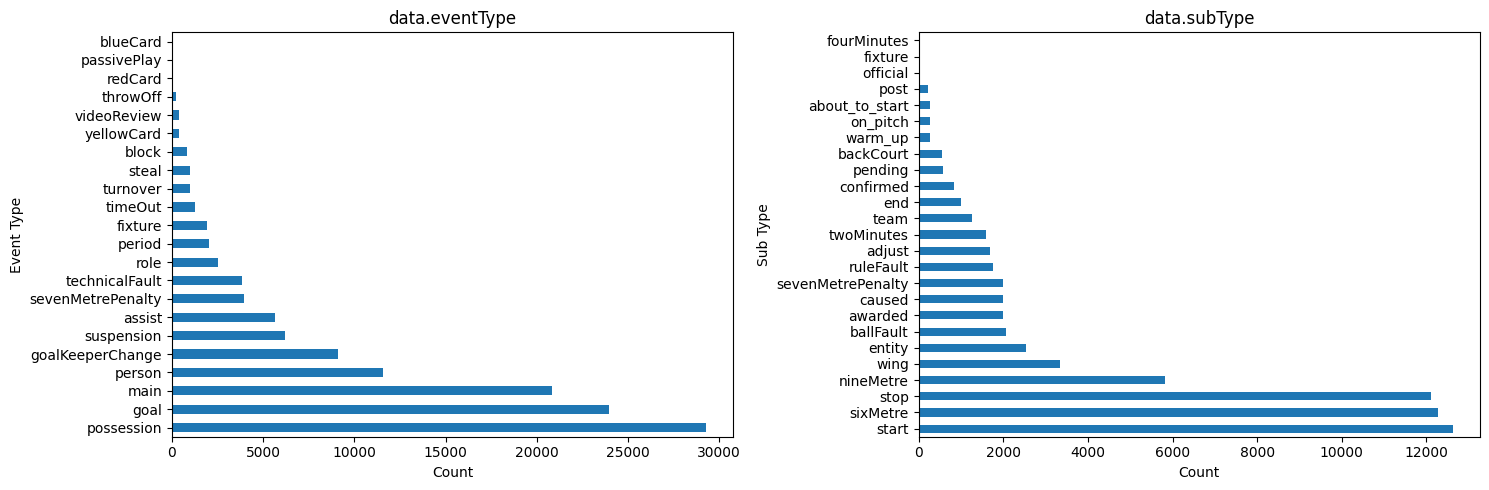

In [4]:
# Histogram of 'data.eventType' and 'data.subType'
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
df["data.eventType"].value_counts().plot(kind="barh", ax=ax[0])
df["data.subType"].value_counts().plot(kind="barh", ax=ax[1])
ax[0].set_title("data.eventType")
ax[1].set_title("data.subType")
ax[0].set_ylabel("Event Type")
ax[1].set_ylabel("Sub Type")
ax[0].set_xlabel("Count")
ax[1].set_xlabel("Count")
plt.tight_layout()
# plt.savefig("eventType_subType.png")
plt.show()

In [5]:
import pandas as pd
import plotly.graph_objects as go

# Count occurrences
counts = df.groupby(["data.class", "data.eventType", "data.subType"]).size().reset_index(name="count")

# Collect all unique labels
labels = pd.concat([counts["data.class"], counts["data.eventType"], counts["data.subType"]]).unique().tolist()
label_indices = {label: i for i, label in enumerate(labels)}

# First flow: type → eventType
sources_type_event = counts["data.class"].map(label_indices)
targets_type_event = counts["data.eventType"].map(label_indices)
values_type_event = counts["count"]

# Second flow: eventType → subType
sources_event_sub = counts["data.eventType"].map(label_indices)
targets_event_sub = counts["data.subType"].map(label_indices)
values_event_sub = counts["count"]

# Combine both flows
sources = pd.concat([sources_type_event, sources_event_sub])
targets = pd.concat([targets_type_event, targets_event_sub])
values = pd.concat([values_type_event, values_event_sub])

# Plot Sankey
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        label=labels,
        line=dict(color="black", width=0.5)
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values
    )
)])

fig.update_layout(
    title_text="Type → EventType → SubType Flow",
    font_size=10,
    height=800,
    width=700
)
fig.show()


In [13]:
import plotly.express as px

df_filtered = df[["data.class", "data.eventType", "data.subType"]].dropna()


fig = px.sunburst(
    df_filtered,
    path=["data.class", "data.eventType", "data.subType"],
    values=None,  # or use a 'count' column if pre-aggregated
    title="Class → EventType → SubType Hierarchy"
)
fig.update_layout(margin=dict(t=40, l=10, r=10, b=10))
fig.show()

fig = px.treemap(
    df_filtered,
    path=["data.class", "data.eventType", "data.subType"],
    values=None,  # or 'count'
    title="Class → EventType → SubType Treemap"
)
fig.update_layout(margin=dict(t=40, l=10, r=10, b=10))
fig.show()


fig = px.icicle(
    df_filtered,
    path=["data.class", "data.eventType", "data.subType"],
    values=None,
    title="Class → EventType → SubType Icicle"
)
fig.update_layout(margin=dict(t=40, l=10, r=10, b=10))
fig.show()

